## 3: Importance sampling for random walks

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### 3.1 1-D Bernoulli random walk

In [3]:
x = 0.5
N = 100
length = 1
# left or right: 0 or 1

### 2.1 (a) Below:
- define random walk sampler to pass to random walk simulation 

In [4]:
def random_walk_sampler(num_steps):
    """ Generate a set of steps for a random walk"""
    X = np.random.rand(num_steps) # samples from a uniform
    # Inverse CDF Trick
    X[X > 0.5] = 1.0
    X[X < 0.5] = -1.0
    return X

In [5]:
def random_walk(num_samples, sample_generator, cumsum=False):

    samples = sample_generator(num_samples)
    if cumsum is False:
        estimate =  np.sum(samples, axis=0)
    else:        
        estimate = np.cumsum(samples, axis=0)
        
    return estimate, samples

Generating random walk paths

In [6]:
g = lambda x: x # identity function
num_trials = 500
num_samples = N
estimator_vals = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
    estimator_vals[trial, :], _ = random_walk(num_samples, random_walk_sampler, cumsum=True)
#     print("one trial: ", estimator_vals[trial, :])

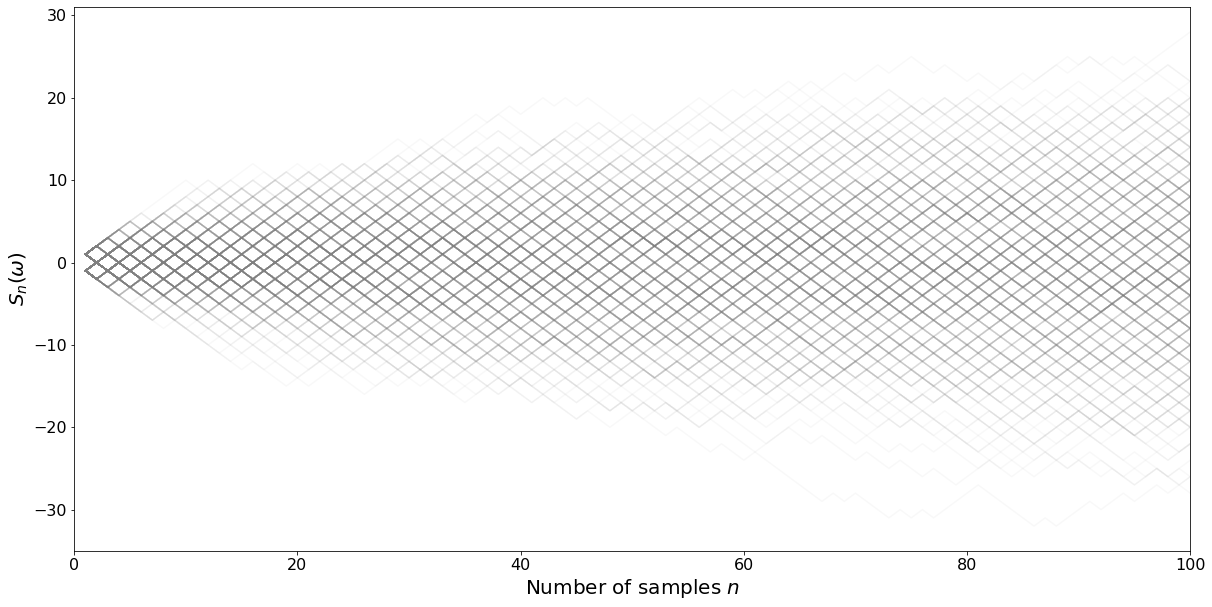

In [7]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1, num_samples+1), estimator_vals.T, color='grey', alpha=0.05)
plt.ylabel(r'$S_n(\omega)$', fontsize=20)
plt.xlabel(r'Number of samples $n$', fontsize=20)
plt.xticks(fontsize=16)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
plt.yticks(fontsize=16)
plt.xlim([0, 100])
# plt.ylim([0, 30])
plt.show()

### 2.1(b) 
- define Monte carlo function below
- then define another function that computes cases when S>10

In [8]:
num_trials = 10**5
def monte_carlo_probability(sample_paths_vs_n, threshold):
    N_paths, _ = sample_paths_vs_n.shape
    s_estimates_satisfy_condition = np.any( sample_paths_vs_n[:,-1:] > threshold, axis = 1 )  # Choose last element which corresponds to N = 100
    s_estimate = np.sum(s_estimates_satisfy_condition) / float(N_paths)
    return s_estimate

P(S>10) =  0.13676
P(S>55) =  0.0


Text(0, 0.5, 'Probability')

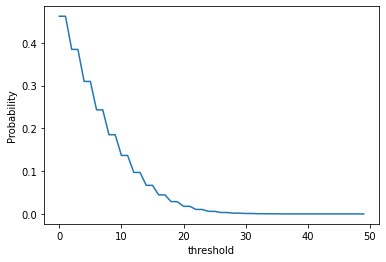

In [9]:
estimator_vals = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
    estimator_vals[trial, :], _ = random_walk(num_samples, random_walk_sampler, cumsum=True)

threshold = 10
print("P(S>10) = ", monte_carlo_probability(estimator_vals, threshold))

threshold = 55
print("P(S>55) = ", monte_carlo_probability(estimator_vals, threshold))

probs = []
for threshold in range(50):
    probs.append(monte_carlo_probability(estimator_vals, threshold))
    
plt.plot(probs)
plt.xlabel('threshold')
plt.ylabel('Probability')


Therefore, probability for steps > about 25 is too low and cannot be computed with standard monte carlo easily. We need importance sampling.

### Actual probability can be calculated as follows:
P(S>10) = 1 - P(S<=10)

Suppose +1 is chosen k times and -1 is chosen 100-k times. Then position at end = $k(1) + (100-k)(-1) = 2k - 100 \leq 10$. Therefore, $k\leq 55$.

\begin{equation}
P(S\leq 10) = \sum_{k=0}^{55} {n \choose k} (0.5)^k (0.5)^{100-k}
\end{equation}

In [58]:
# Actual Probability
from math import factorial
def comb(n, k):
    return factorial(n) / factorial(k) / factorial(n - k)

prob = 0
for k in range(56):
    prob = prob + comb(100,k)
print(prob)
prob = prob * 0.5**100
print("Actual P(S>10) = ", 1 - prob)

1.09572357083777e+30
Actual P(S>10) =  0.13562651203691733


### 2.1 (c)
- Importance sampling with $10^5$ trials for P(S>55)
- Next we try importance sampling with a proposal DISCRETE distribution that puts more probability on getting $X_i=1$.

𝜋: P(1) = 0.8, P(-1) = 0.2


This is because, we want to use importance sampling on $X_i$ and therefore the only way we can do this is by shidting probability towards 1.0

In [11]:
shift = 0.1

def shifted_random_walk_sampler(num_steps):
    """ Generate a set of steps for a random walk"""
    X = np.random.rand(num_steps) # samples from a uniform
    # Inverse CDF Trick
    X[X > shift] = 1.0
    X[X < shift] = -1.0
    return X

def prob_normal_walk(sample):
    return 0.5

def prob_shifted_walk(sample):
    if sample>0:
        return 1 - shift
    else:
        return shift

In [12]:
def random_walk_weighted(num_samples, sample_generator, cumsum=False):

    samples = sample_generator(num_samples)
    weighted_samples = np.asarray([ sample * prob_normal_walk(sample) / prob_shifted_walk(sample) for sample in samples])
    if cumsum is False:
        estimate =  np.sum(weighted_samples, axis=0)
    else:        
        estimate = np.cumsum(weighted_samples, axis=0)
        
    return estimate, samples

def monte_carlo_importance(sample_paths_vs_n, threshold):
    N_paths, _ = sample_paths_vs_n.shape
    s_estimates_satisfy_condition = np.any( sample_paths_vs_n[:,-1:] > threshold, axis = 1 )  # Choose last element which corresponds to N = 100
    s_estimate = np.sum(s_estimates_satisfy_condition) / float(N_paths)
    return s_estimate

P(S>55) =  5e-05


Text(0, 0.5, 'Probability')

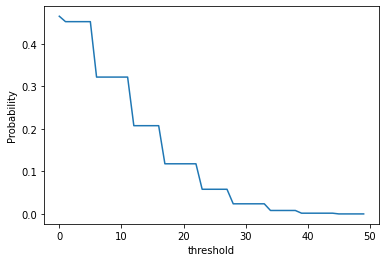

In [13]:
num_trials = 10**5
estimator_vals_importance = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
    estimator_vals_importance[trial, :], _ = random_walk_weighted(num_samples, shifted_random_walk_sampler, cumsum=True)

threshold = 55
print("P(S>55) = ", monte_carlo_importance(estimator_vals_importance, threshold))

probs = []
for threshold in range(50):
    probs.append(monte_carlo_importance(estimator_vals_importance, threshold))
    
plt.plot(probs)
plt.xlabel('threshold')
plt.ylabel('Probability')

Actual probability can be calculated as follows:
P(S>55) = 1 - P(S<=55)

Suppose +1 is chosen k times and -1 is chosen 100-k times. Then position at end = $k(1) + (100-k)(-1) = 2k - 100 \leq 55$. Therefore, $k\leq 77.5$.

\begin{equation}
 P(S\leq 55) = \sum_{k=0}^{77} {n \choose k} (0.5)^k (0.5)^{100-k}
\end{equation}


In [14]:
# Actual Probability
from math import factorial
def comb(n, k):
    return factorial(n) / factorial(k) / factorial(n - k)

prob = 0
for k in range(78):
    prob = prob + comb(100,k)
print(prob)
prob = prob * 0.5**100
print("Actual P(S>55) = ", 1 - prob)

1.26765059014703e+30
Actual P(S>55) =  7.952664082822025e-09


### 2.1 (e) (i) Monte Carlo errors

In [15]:
def mc_estimate_of_probability(num_trials, num_samples, threshold=10):
    estimator_vals = np.zeros((num_trials, num_samples))
    for trial in range(num_trials):
        estimator_vals[trial, :], _ = random_walk(num_samples, random_walk_sampler, cumsum=True)
    return monte_carlo_probability(estimator_vals, threshold)

def replicates(num_replicate, num_samples, true_value, threshold=10):
    # One replicate
    probability_estimates = np.zeros(num_replicate)
    for run in range(num_replicate):
        probability_estimates[run] = mc_estimate_of_probability(100000, num_samples, threshold)

    print(probability_estimates)
    z = 2
    std_error =np.std(probability_estimates)#/np.sqrt(num_replicate) sigma/sqrt(n) is the std deviation of Sn. Therefore no need to divide by sqrt(n)
    
    print("std error", z*std_error)
    
    success = 0
    for run in range(num_replicate):
        Sn = probability_estimates[run]
        bound_lower = Sn - z*std_error
        bound_upper = Sn + z*std_error
        if true_value<=bound_upper and true_value>=bound_lower:
            success = success + 1
            
    return success/num_replicate
    
replicates(100,num_samples, 0.135626, threshold=10)

     

[0.13598 0.13477 0.13452 0.13491 0.1336  0.13649 0.13559 0.1361  0.13313
 0.13535 0.13596 0.13527 0.13486 0.13466 0.13426 0.13501 0.13645 0.13719
 0.13551 0.13588 0.13477 0.13633 0.13546 0.13496 0.13495 0.13589 0.13564
 0.1377  0.13507 0.13565 0.1364  0.13749 0.13763 0.13528 0.13582 0.13562
 0.13514 0.13512 0.13609 0.13777 0.1339  0.13546 0.13396 0.13404 0.13496
 0.13661 0.13458 0.13584 0.13555 0.1365  0.1365  0.13624 0.1366  0.13745
 0.13442 0.13601 0.13623 0.13391 0.1351  0.13464 0.13334 0.13458 0.13615
 0.13449 0.13491 0.13586 0.13686 0.13809 0.13721 0.13521 0.1352  0.13522
 0.13545 0.13684 0.13497 0.13573 0.13709 0.13572 0.13508 0.1348  0.13637
 0.134   0.1341  0.13814 0.13536 0.13784 0.13764 0.13433 0.13411 0.13517
 0.1358  0.13552 0.13497 0.13544 0.13641 0.13454 0.13621 0.13539 0.13651
 0.13427]
std error 0.002182282648971026


0.95

#### MC error with Running mean from trials $1$ to $10^5$

In [ ]:
def monte_carlo_probability_running_mean(sample_paths_vs_n, threshold):
    s_estimate = []
    for i in range(np.shape(sample_paths_vs_n)[0]):
        N_paths, _ = sample_paths_vs_n[0:i+1,:].shape
        s_estimates_satisfy_condition = np.any( sample_paths_vs_n[0:i+1,-1:] > threshold, axis = 1 )  # Choose last element which corresponds to N = 100
        s_estimate.append(np.sum(s_estimates_satisfy_condition) / float(N_paths))
    return s_estimate

def mc_estimate_of_probability_running_mean(num_trials, num_samples, threshold=10):
    estimator_vals = np.zeros((num_trials, num_samples))
    for trial in range(num_trials):
        estimator_vals[trial, :], _ = random_walk(num_samples, random_walk_sampler, cumsum=True)
    return monte_carlo_probability_running_mean(estimator_vals, threshold)

def replicates_running_mean(num_replicate, num_samples, true_value, threshold=10):
    # One replicate
    probability_estimates = np.zeros((num_replicate, 100000))
    for run in range(num_replicate):
        probability_estimates[run,:] = mc_estimate_of_probability_running_mean(100000, num_samples, threshold)
    
    print("estimator shape", np.shape(probability_estimates))
    return probability_estimates
num_replicate = 1000
probability_estimates = replicates_running_mean(num_replicate,num_samples, 0.135626, threshold=10)


In [64]:
# plt.plot(probability_estimates)
np.sum(probability_estimates>0.13)

198860

In [73]:
def calculate_success_rates(probability_estimates, num_replicate,true_value):
    z = 2
    std_error =np.std(probability_estimates, axis=0)#/np.sqrt(num_replicate) sigma/sqrt(n) is the std deviation of Sn. Therefore no need to divide by sqrt(n)
    
    print("std error", np.shape(std_error))

    success = np.zeros(100000)
    for run in range(100000):
        Sn = probability_estimates[:, run]
        for i in range(num_replicate):
            bound_lower = Sn[i] - z*std_error[run]
            bound_upper = Sn[i] + z*std_error[run]
            if true_value<=bound_upper and true_value>=bound_lower:
                success[run] = success[run] + 1
            
    return success/num_replicate

success_rates = calculate_success_rates(probability_estimates, num_replicate, true_value=0.135626)

std error (100000,)


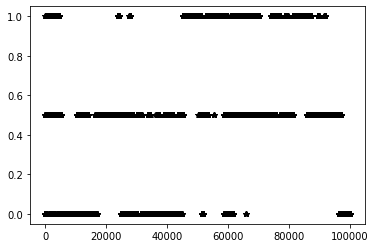

In [76]:
np.max(success_rates)
# success_rates
plt.plot(success_rates,'k*')

## 2.2 3-D Gaussian Random Walk

2.2(a)

In [21]:
def Gaussian_random_walk_sampler(num_steps):
    """ Generate a set of steps for a random walk"""
    num_dim = 3
    X = np.random.normal(size = (num_dim,num_steps)) # samples from a uniform
    return X

def gaussian_random_walk(num_samples, sample_generator, cumsum=False):

    samples = sample_generator(num_samples)
    if cumsum is False:
        estimate =  np.sum(samples, axis=0)
    else:        
        estimate = np.cumsum(samples, axis=0)
        
    return estimate, samples

Text(0, 0.5, 'Distance of agent')

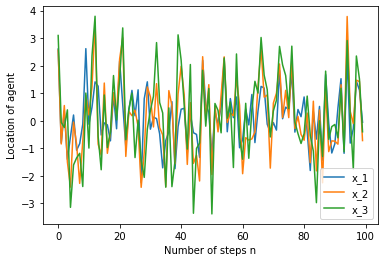

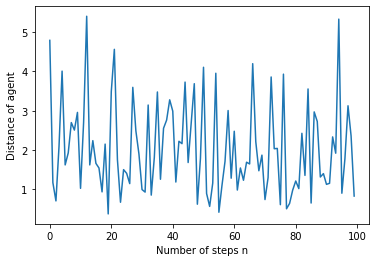

In [22]:
N = 100
path, samples = gaussian_random_walk(N, Gaussian_random_walk_sampler, cumsum = True)

plt.figure()
plt.plot(path[0,:], label = r'x_1')
plt.plot(path[1,:], label = r'x_2')
plt.plot(path[2,:], label = r'x_3')
plt.xlabel('Number of steps n')
plt.ylabel('Location of agent')
plt.legend()

plt.figure()
plt.plot(np.linalg.norm(path, axis=0))
plt.xlabel('Number of steps n')
plt.ylabel('Distance of agent')

### 2.2(b)

In [23]:
num_trials = 10**5
num_samples = N
estimator_gaussian_vals = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
        path, _  = gaussian_random_walk(num_samples, Gaussian_random_walk_sampler, cumsum=True)
#         print("path shape", path.shape)
#         print("|S| shape", np.linalg.norm(path, axis=0).shape)
        estimator_gaussian_vals[trial, :] = np.linalg.norm(path, axis=0)
print(estimator_gaussian_vals.shape )

(100000, 100)


### Calculating probabilities

P(|S|>10) =  1e-05
P(|S|>55) =  0.0


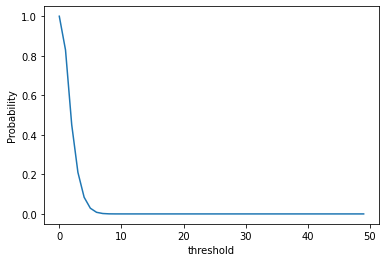

In [27]:
threshold = 10
print("P(|S|>10) = ", monte_carlo_probability(estimator_gaussian_vals, threshold))

probs = []
for threshold in range(50):
    probs.append(monte_carlo_probability(estimator_gaussian_vals, threshold))
    
plt.plot(probs)
plt.xlabel('threshold')
plt.ylabel('Probability')

threshold = 55
print("P(|S|>55) = ", monte_carlo_probability(estimator_gaussian_vals, threshold))

Note here that the above probability variance is very high even with num_trials = $10^5$. Most of the times, the probability will come out to be 0. Other times it is $10^{-5}$

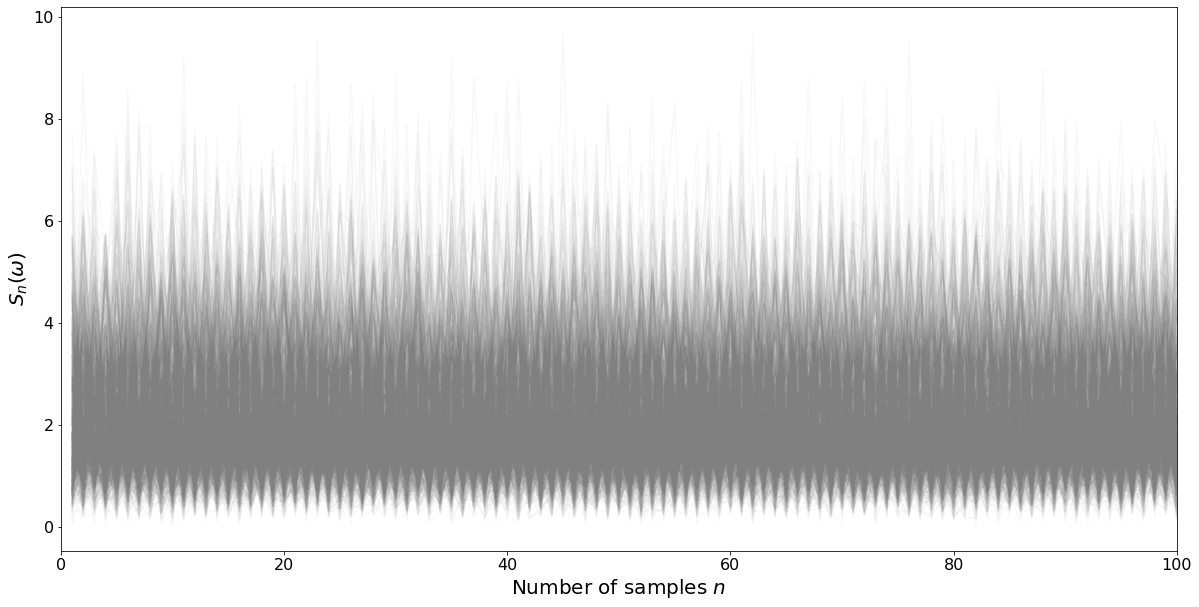

In [159]:
# plt.figure(figsize=(20,10))
# plt.plot(np.arange(1, num_samples+1), estimator_gaussian_vals.T, color='grey', alpha=0.05)
# plt.ylabel(r'$S_n(\omega)$', fontsize=20)
# plt.xlabel(r'Number of samples $n$', fontsize=20)
# plt.xticks(fontsize=16)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
# plt.yticks(fontsize=16)
# plt.xlim([0, 100])
# # plt.ylim([0, 30])
# plt.show()

### 2.2 (c)

In [28]:
def shifted_Gaussian_random_walk_sampler(num_steps):
    """ Generate a set of steps for a random walk"""
    num_dim = 3
    X = np.random.normal(loc = (2/np.sqrt(3)), size = (num_dim,num_steps)) # samples from a uniform
    return X

def prob_normal_gaussian_walk(sample):
    return 1/np.sqrt(2*np.pi)*np.exp(-(sample)**2/2)

def prob_shifted_gaussian_walk(sample):
    shift_gaussian = 2/np.sqrt(3)
    return 1/np.sqrt(2*np.pi)*np.exp(-(sample-shift_gaussian)**2/2)

def gaussian_random_walk_weighted(num_samples, sample_generator, cumsum=False):

    samples = sample_generator(num_samples)
    weighted_samples = np.asarray([ sample * prob_normal_gaussian_walk(sample) / prob_shifted_gaussian_walk(sample) for sample in samples])
    if cumsum is False:
        estimate =  np.sum(weighted_samples, axis=0)
    else:        
        estimate = np.cumsum(weighted_samples, axis=0)
        
    return estimate, samples



P(S>55) =  0.00272


Text(0, 0.5, 'Probability')

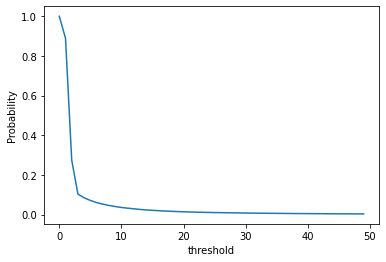

In [29]:
num_trials = 10**5
estimator_vals_importance = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
    path, _  = gaussian_random_walk_weighted(num_samples, shifted_Gaussian_random_walk_sampler, cumsum=True)
    estimator_vals_importance[trial, :] = np.linalg.norm(path, axis=0)
    

threshold = 55
print("P(S>55) = ", monte_carlo_importance(estimator_vals_importance, threshold))

probs = []
for threshold in range(50):
    probs.append(monte_carlo_importance(estimator_vals_importance, threshold))
    
plt.plot(probs)
plt.xlabel('threshold')
plt.ylabel('Probability')

In [62]:
a = np.array([ [1,2],[3,4] ])
np.shape(a[0:0,:])

(0, 2)